# Introduction to Deep Learning

In [1]:
# Import Libraries
# Utility libraries
import numpy as np # Math & array handling
import pathlib # Pathing for directories & other files

# Data handling/Preprocessing libraries
import pandas as pd
from sklearn.model_selection import train_test_split #preprocessing
from PIL import Image # For viewing mnist images

# Neural Network libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Plotting libraries
import matplotlib.pyplot as plt #For basic plotting
from plotnine import * #ggplot analogue

In [2]:
# Clone in files from github
!git clone --quiet https://github.com/modern-data-mining/Lecture-Neural-Network.git

# Objective

This lecture provides an introduction to Neural Networks and Convolutional Neural Networks. We will see how neural networks borrow ideas from cognitive science and models the behavior of neurons so as to mimic the perception process of human beings. On a high level, Neural Network is a "parametric" model with huge number of unknown parameters. It is easy to understand the entire set up with knowledge of regressions. Thanks to the CS people who have been developing efficient, fast computation algorithms we are able to estimate millions of unknown parameters within no time. 

Though the neural network model is easy for us to understand, there are a set of new terminologies introduced. Based on the neural network model, we will set up the architecture (model specification) with input layer, hidden layers and output layer and apply the package to several case studies. A well known case study MNIST will be carried out here through the basic NN. 

Since the most successful application of deep learning (Neural Network with more layers) is image recognition and Language processing among others, we will also explore the image-specialized Convolutional Neural Network (CNN) and see how it performs compared to the regular neural network on MNIST. The core of CNN is the convolutional layer and the pooling layer. 

While keeping this lecture compact with core ideas about NN we have left many details out.  If you are interested to learn more, you can refer to this wonderful [Neural Networks course](http://cs231n.github.io). We will use some graphic illustrations from there. Also a well organized website with data mining elements including Neural Networks can be found 
[HERE](http://ufldl.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks/).

**Acknowledgment**: This lecture is built gradually and expanded to the current real implementable shape. Several former TAs have been contributing to the success of current version. It is impossible without their help. Junhui Cai (current Ph.D student in the stat dept), John Brooke Waldt (former MS student in CS department) and Ryan Galea (former MBA student), I thank them!

# Introduction

Table of Contents


1. Installation
    + Python
    + Tensor Flow
    + Keras 
2. Neural Network
    + Modelling: Non-linear, large number of parameters
    + Architecture: 
        - Input layer, Hidden layer, Output layer
        - Neuron, Activation functions
        - Weights (coefficients)
    + Loss functions:
        - N-entropy (same as -loglikelihood for categorical output)
        - Sum of Squared errors (continuous output)
    + Minimization:
        - Stochastic Gradient Decent (SGD) (Details in Appendix)
        - Back-propagation (Chain rule)
3. Two cases:
    + Binary Classification: Yelp Review 
    + Multiclass Classification: MNIST Digit Recognition
        - Image processing
        - Classification with 10 classes
        
4. Convolutional Neural Network (CNN) (Put in a seperate lecture)
    + Architecture: Convolutional layer, Pooling layer
    + CNN with MNIST (Black/White)
    + CNN with CIFAR10 (Colored Images with 10 classes)

5. Data needed:
    + `YELP_tm_freq.csv` 
    + `MNIST` available with `keras`
    + A few images needed


Appendix

  + Gradient Descent
  + MNIST with RF

Note: 

  + K layers recommended if K classes.
  + For regression
      - the last layer: layer_dense(units = 1)
      - model %>% compile(optimizer = "rmsprop", loss = "mse",  metrics = c("mae") mean absolute error (MAE)
          
  + Can take k-fold cv to build a model


## Python and Keras

*Python* is another commonly-used programming language, especially in machine learning community. A lot of popular libraries, including Tensor flow and Keras that we will use in this lecture, are developed in Python. 

Google Colab is a convenient, popular, and free development environment that allows you to write and execute Python from your browser. We won't use them in this lecture, but to develop more computationally intensive models, Colab also provides access to GPUs and TPUs built into its interface. 

*TensorFlow* is a machine learning library developed by Google. *Keras* is a high-level Application Programming Interface (API) for TensorFlow to build and train deep learning models. It runs on top of TensorFlow and is used for fast prototyping, advanced research, and production. 

### Keras for R

While not covered in this lecture, it is also possible to develop neural networks in R. We have included information on this in the Appendix.

# Neural Network

We have discussed various machine learning methods in previous lectures. *Deep learning* is another one of these approaches. From data, it attempts to learn successive layers of increasing meaningful representation.

Let's consider a classification problem. For each sample $(X_i, Y_i)$ where $i = 1, \ldots, n$, we have 

* $\mathbf X_i = (X_{i1}, \ldots, X_{ip})$ is a $p$-dimensional input features
* $\mathbf Y_i = (Y_{i1}, \ldots, Y_{iK})$ is a $K$-dimensional class indicator
    + for continuous response, $K=1$
    + for $K$-class classification, $Y_{ij} = 1$ if it is of class $j$ where $j = 1, \ldots, K$

Given the features/predictors, we would like to build a probability model for y (categorical). We then can predict y accordingly. Or build a predictive equation for a continuous response y. 

## Prelude: logistic regression

Logistic regression is the most popular model to model the relationship between probability of one level of y vs. all the predictors.  For example, we have 3 covariates $(x_1, x_2, x_3)$ and a label $y \in \{0,1\}$. We model probability of $P(y=1|x_1, x_2, x_3)$ through a linear logit link function: 

$logit(Prob(Y=1 | X_1, X_2, X_3)) = \beta_0 + \beta_1 X_1 +  \beta_2 X_2 +  \beta_3 X_3  $

Or equivalently this is same to model 
$Prob(Y=1 | X_1, X_2, X_3) = \frac{e^{\beta_0 + \beta_1 X_1 +  \beta_2 X_2 +  \beta_3 X_3}}
{1+ e^{\beta_0 + \beta_1 X_1 +  \beta_2 X_2 +  \beta_3 X_3}}$

Let us rephrase the model process in the following neural network with only an input layer and an output layer.

* **Input layer** consists of 3 input units (3 features): $x_1, x_2, x_3$
* **Output layer**: contains $s_1, s_2$:
  $s_1 = b_{1}^{(1)} + W_{11}^{(1)}x_1 + W_{12}^{(1)}x_2 + W_{13}^{(1)}x_3$  
    $s_2 = b_{2}^{(1)} + W_{21}^{(1)}x_1 + W_{22}^{(1)}x_2 + W_{23}^{(1)}x_3$  
* **Softmax**: models:  
$Prob(Y=1|x_1, x_2, x_3) = \frac{e^{s_1}}{e^{s_1}+e^{s_2}}$  
$Prob(Y=0|x_1, x_2, x_3) = \frac{e^{s_2}}{e^{s_1}+e^{s_2}}$  
   
The following figure illustrates the model above.

<img src='https://raw.githubusercontent.com/sjpl/placeholder/main/img/logit.png' width=50%>

We only need to estimate the first set of unknown parameters:  
$b_{1}^{(1)}, W_{11}^{(1)}, W_{12}^{(1)},  W_{13}^{(1)}$ since
$P(Y=1) + P(Y=0) = 1$  

**The above classical logistic regression model is a simple network:**

- 0 layer

- softmax as output (meaning logit function)

- classification is done through thresholding the probability

- it is simple and we can interpret the probability model

- BUT, it is restrictive for the model format. 

A natural way to expand the logistic regression model is to include non-linear equations for $s_1$ and $s_2$. One way to do it is by creating many intermediate composite functions sequentially, starting from the input, layer by layer to the output layer. This is called a Neural Network. 

## Architecture

We can use a diagram to describe the architecture of a neural network. A neural network consists of three major layers: an input layer, hidden layers, and an output layer. When we say $N$-layer neural network, we do not count the input layer by convention.


As a simple example, consider the setup: we have $(x_1, x_2, x_3, y)$, where there are 3 features and one binary response. Let's start with the following neural network with **one hidden layer** where one hidden layer consists of **4 neurons**. We have 3 features for each data point and 2 classes to predict. 

<img src='https://raw.githubusercontent.com/modern-data-mining/Lecture-Neural-Network/main/img/nn.png?token=AE4SBUE2UAAVLAVTBGRI7DTBBKU6Y' width=50%>

For each data point $(x,y)$, 

* **Input layer** consists of **3 input** units (3 features): $x_1, x_2, x_3$
* **Hidden layer** consists of **4 neurons**. Each neuron is given by first taking a linear combination then apply an **activation** function $f_1$  

    $a_1^{(1)} = f_1(b_{1}^{(1)} + W_{11}^{(1)}x_1 + W_{12}^{(1)}x_2 + W_{13}^{(1)}x_3)$
    $a_2^{(1)} = f_1(b_{2}^{(1)} + W_{21}^{(1)}x_1 + W_{22}^{(1)}x_2 + W_{23}^{(1)}x_3)$
    $a_3^{(1)} = f_1(b_{3}^{(1)} + W_{31}^{(1)}x_1 + W_{32}^{(1)}x_2 + W_{33}^{(1)}x_3)$
    $a_4^{(1)} = f_1(b_{4}^{(1)} + W_{41}^{(1)}x_1 + W_{42}^{(1)}x_2 + W_{43}^{(1)}x_3)$  
where $a_i^{(1)}$ denotes the $i$-th activated neuron in hidden layer 1.  
* $f_1(x)$ is called an activation function. Here we take **ReLU** function:
\[f_1(x) = \max (0, x) \]

* **Output layer** consists of 2 output units
    $s_1 = b_{1}^{(2)}+W_{11}^{(2)}a_1^{(1)} + W_{12}^{(1)}a_2^{(1)} + W_{13}^{(1)}a_3^{(1)} + W_{14}^{(1)}a_4^{(1)}$  
    $s_2 = b_{2}^{(2)}W_{21}^{(2)}a_1^{(1)} + W_{22}^{(1)}a_2^{(1)} + W_{23}^{(1)}a_3^{(1)} + W_{24}^{(1)}a_4^{(1)}$
   
* **Softmax**: models:
$Prob(Y=1|x_1, x_2, x_3) = \frac{e^{s_1}}{e^{s_1}+e^{s_2}} = \frac{e^{b_{1}^{(2)}+W_{11}^{(2)a_1^{(1)} + W_{12}^{(1)}a_2^{(1)} + W_{13}^{(1)}a_3^{(1)} + W_{14}^{(1)}a_4^{(1)}} }}{e^{s_1}+e^{s_2}}$  
$Prob(Y=0|x_1, x_2, x_3) = \frac{e^{s_2}}{e^{s_1}+e^{s_2}}=\frac{e^{ b_{2}^{(2)}W_{21}^{(2)}a_1^{(1)} + W_{22}^{(1)}a_2^{(1)} + W_{23}^{(1)}a_3^{(1)} + W_{24}^{(1)}a_4^{(1)}} }{e^{s_1}+e^{s_2}}$

* **Unknown parameters:** All weights $W^{(1)}$'s, $b^{(1)}$'s and  $W^{(2)}$'s, $b^{(2)}$' are unknown parameters.

 To write in a compact way, we have the following unknown: the hidden layer $W^{(1)}$ is a matrix of $3\times 4$, $b^{(1)}$ is $4\times 1$ and the output layer $W^{(2)}$ is $4\times 1$ and $b^{(2)}$ is $1\times 1$ with a total number of $12+4+4+1=21$ parameters. 
 

**This model is different from the classical logistic regression model** since we have introduced the non-linear part in the model. 

Summarize a general neural network or architecture:

* **Input layer**: holds the input training data

* **Hidden layer** (Fully-connected layer): computes the neurons according to a weight matrix $W$. We need to specify the number of hidden layers, the number of neurons in each hidden layer and the activation function.

  + **Number of hidden layers (depth)** basically controls how deep we want the network to be. The more hidden layers the more complex our model is and hence the so called **deep learning**.
  + **Number of neurons** controls how many neurons we want for each hidden layer.
  + **Activation function**. As mentioned, ReLU is a commonly-used activation function and Softmax is usually used for the last hidden layer to output class scores to output layer.
  + **Weight matrix** is a matrix of unknown coefficients. Each column is the $W$'s above for each neuron. Note that for a hidden layer with $q$ neurons, if we have a $p$-dimensional input, the weight matrix for this hidden layer will be $(p+1) \times q$ where the additional $1$ corresponds to the bias term or the `intercept` term. 

* **Output layer**: contains the class scores for classification. The dimension is usually the same as the number of classes. 

Neural network described above is flexible to handle

* **y can have K many levels**: we only need to output $s_1, s_2,...s_K$ one for each outcome.

* **y can be continuous**: output  one $s_1$.

### Activation functions  

Commonly used activation function can be any of the following non-linear functions:   

- Rectified Linear Unit (ReLU, pronounce as REL-loo) - Quicker to train!!   
    $$f=max(0, x)$$

- Logit/Sigmoid:    
    $$f = \frac{1}{1+e^{-x}}$$
    
- Hyperbolic Tangent: - Similar to logit
    $$f=\tanh(x)$$

The most commonly used activation function is **ReLU** because it converges faster with simple implement (by thresholding). The **leaky ReLU**, $f=max(\epsilon x, x)$, is also used in very deep network.

The following figures show the shape of activation functions

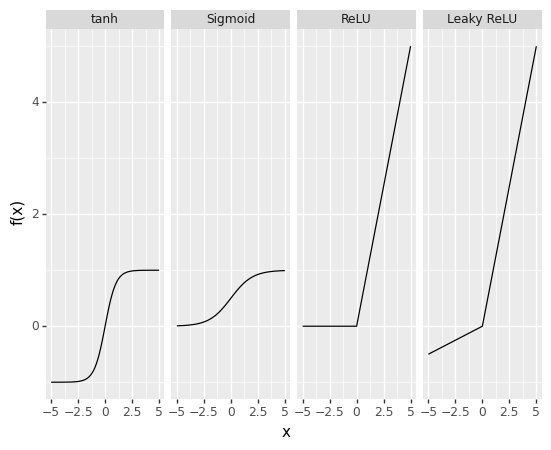

<ggplot: (8768328620605)>

In [40]:
x = np.linspace(-5,5,num=101)
x_len = np.size(x)
tanh_y = np.tanh(x)
sigmoid_y = 1/(1+np.exp(-x))
relu_y = np.maximum(0,x)
eps = 1e-1
relu_leaky_y = np.maximum(eps*x,x)

act_func = ["tanh","Sigmoid","ReLU","Leaky ReLU"]
act_func_order = pd.CategoricalDtype(act_func, ordered=True)
d = {"method": np.repeat(act_func,x_len), 
     "x": np.tile(x,4), 
     "y": np.concatenate((tanh_y, sigmoid_y, relu_y, relu_leaky_y))}
act_func_df = pd.DataFrame(d)
act_func_df['method'] = act_func_df['method'].astype(act_func_order)
act_func_df.sort_values('method')
    
(ggplot(act_func_df, aes(x='x', y='y'))
+ geom_line()
+ facet_wrap( '~ method', nrow=1)
+ ylab("f(x)"))

### Connections with biological/cognitive science

The basic computational unit of the brain is a neuron, as shown in the first figure below.  Each neuron receives signals (impulses) from other neurons and processes and produces output signals to other neurons. Analogously, Neural network receives the input matrix, processes the input and output the signal with an activation function $h$ in the picture or $f$ in our notation.

<table><tr>
<td><img src="https://raw.githubusercontent.com/sjpl/placeholder/main/img/neuron.png" style="width=100%"></td>
<td><img src="https://raw.githubusercontent.com/sjpl/placeholder/main/img/neuron_model.jpg" style="width=40%"></td>
</tr></table>


## Loss functions

Once a model is specified or an architecture is defined, we then need to estimate all the weights and biases (or all the unknown parameters). The standard loss for classification is the **cross entropy** which is exactly the -log likelihood function. We then minimize the **cross entropy** or maximize the log likelihood to get all the unknown parameters. 

* **Logistic loss classifier**
  $$L = - \frac{1}{n}\sum_{i=1}^n\sum_{j=1}^K 1 y_{ij} \log(p_{ij})$$
  where $p_{i,j}$ is the probability of $i$ being in class $j$.
  
* **Softmax classifier**: one of the most popular choices. Denote the scores in the output layer as $(s_1, \ldots, s_K)$. Then the loss function is 
  $$L = - \frac{1}{n}\sum_{i=1}^n \sum_{j=1}^K 1 y_{ij} \log\Bigg(\frac{e^{s_{y_{ij}}}}{\sum_j e^{s_{ij}} } \Bigg)$$

**Remark**: For the softmax we take:
* $$p_j=Prob(Y=j|x_1, ... x_p) = \frac{e^ {s_j}}{\sum_{j=1}^{j=K} {e^ {s_j}}}$$
  Here K is number of classes. 

* The second sum for each subject $i$ there is only one $y_{i, j} \neq 0$.

## Regularization

As we have seen, the number of parameters grows fast as we specify more hidden layers. Over-parameterization can lead to overfitting. There are two major ways to regularize the model.

* $L_1$ or $L_2$ penalty term to shrink parameters
    + Just like Ridge or Lasso
    + Do not need to do Feature Selection before hand
* Dropout 
    + The most popular way
    + Randomly (temporarily) remove a fraction of the neurons (with replacement). The figure is taken from the [Dropout paper](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf) by Srivastava et. al.

<img src="https://raw.githubusercontent.com/sjpl/placeholder/main/img/dropout.jpg">

## Fitting models

To fit the model, we will find the minimizers of all the coefficients like we did in glm. Here the number of parameters are huge. So fast, efficient algorithms are needed. This is where tensor flow gets in. **gradient descent** combined with the trick of **back-propagation** did it.  (You may skip the remaining paragraphs which are rather technical about the minimization problems.)

In this course, we barely mention how packages actually solve the optimization problems. Optimization is a very general yet crucial field and has been developing for years. Neural networks and deep learning could not have been so popular without recent development in optimization (and of course computation power). Refer to an excellent [convex optimization course](http://www.stat.cmu.edu/~ryantibs/convexopt/) if you are interested. 

The most important optimization techniques for neural networks and deep learning are **gradient descent** and **back-propagation**. These are NOT new ideas as neural networks! Gradient descent was invented by Cauchy in 1847 and back-propagation was popularized by [Rumelhart, Hinton (one of three Turning Award 2018 laureates) and Williams](http://www.cs.toronto.edu/~hinton/absps/naturebp.pdf) (17k citations!) in 1986 (Back-propagation was derived by multiple researches in early 60's). 

**Gradient descent** is an algorithm to find the maximizer/minimizer (using the first-order information, i.e. gradient). There are lots of developments in recent years to accelerate (e.g. stochastic gradient descent (SGD), Momentum, adaptive gradient descent (Adagrad), RMSprop). For neural networks, it is worth mentioning that since the loss function is generally not convex, gradient descent does not guarantee global convergence and is often trapped in saddle points. Research in escaping the saddle point and, in general, non-convex optimization is very active.

There exists other algorithm for example the Newton's method that uses the second-order information, i.e. Hessian. The second-order methods enjoy a faster convergence rate. In reality, however, computing the Hessian for millions of parameters is very expensive. Hence it it not common to apply second-order methods to large-scale deep learning.

**Back-propagation** is a technique to calculate the gradients for gradient descent. It is a simple yet power idea using chain rule. Each iteration needs to update millions of parameters using gradient descent and thus needs to compute millions of gradients. Back-propagation starts from the last layer and computes the gradients for parameters of the last layer, and then backprops (passes the gradients) to the previous layer to compute the gradients for parameters of the second last layer and so on. Backpropagation then allows us to efficiently compute the gradients and then update the parameters. 

**A detailed explanation about GD/SGD is provided in the Appendix!!**

We are now ready to use Keras to implement neural networks with real case studies. 

# Case 1: Yelp Textmining NN

How well can we predict ratings from a review? The Yelp data available to us here is 100000 previous reviews together with ratings. Use bag of words, each review is already processed in the term frequency format. There are  $p=1072$ words retained. The response variable is a binary `rating`, 1 being a good review and 0 being a bad review. 

In this section we will implement a Neural Network model with two layers and varying number of neutrons. Package `keras` is used. 

## Data Preparation

**Read the data**:  `YELP_tm_freq.csv` contains processed Yelp data. It contains the response `ratings`and reviews. In `yelpdata2`: the first variable is the response `rating` and the remaining variables are words or input of $x_1, \ldots, x_{1072}$.

In [4]:
# Unzip dataset from github download
zip_path = "/content/Lecture-Neural-Network/data/YELP_tm_freq.zip"
!unzip -q {zip_path}

In [5]:
data_path = "/content/YELP_tm_freq.csv"
yelpdata = pd.read_csv(data_path)

In [6]:
yelpdata.head() # notice that user_id, stars and date are in the dataset
yelpdata.shape
yelpdata.ndim
yelpdata.columns[0:5] #Note, Python uses zero-based array indexing

yelpdata2 = yelpdata.iloc[:,3:] # Remove extra cols. First col will be the rating.
yelpdata2.head()
yelpdata2.dtypes

rating      int64
abl         int64
absolut     int64
accept      int64
accommod    int64
            ...  
you         int64
young       int64
your        int64
yum         int64
yummi       int64
Length: 1073, dtype: object

**Data preparation for NN**:

  + We need to split data into two sets: training data and validation
  + Training data will be split internally to tune any parameters
  + We reserve the validation data set to give an honest evaluation for the testing error. That is the only time it will be used.
  + All the data **needs** to be either matrices or vectors.

**Training data: `x_train`/`y_train`**: Use 90,000 as the training data. Internally we need to split this training data again to tune the parameters. Keras refer the split internal datasets as training/validation. (We call this pair our training/testing datasets.)

**Validation data: `x_val` / `y_val`**: reserve 10,000 from the total dataset.

In [7]:
# Split into input & y (the label)
yelp_rating = yelpdata2.iloc[:,0] # Labels
yelp_words = yelpdata2.iloc[:,1:] # Inputs

# Convert to a matrix for keras compatibility
yelp_rating = np.array(yelp_rating)
yelp_words = np.array(yelp_words)

# test_size = 0.10 to reserve 10,000 for validation
# use random_state=1 for reproducibility
x_train, x_val, y_train, y_val = train_test_split(
    yelp_words, yelp_rating, test_size=0.10, shuffle=True, random_state=1)
# np.shape(x_train)

# keras further splits x_train and y_train internally into 'training' and 'testing' datasets

### Fully Connected Neural Network

Now the data is prepared, let's begin working with our full dataset using the `keras` package. The first step is to define our model. By defining, we mean specifying the number and type of layers to include in our model and what will happen to our data in each layer. For our purposes `keras_model_sequential()` is the function to run when defining our model. 

To add a fully connected or dense layer we use the command `layer_dense()`.

When building the layer, the shape of the input needs to be specified. This refers to the length of each input vector, which in our case is 1072 (the 1072 possible words in our frequency dictionary).

We also need to specify how many hidden units our layer will contain (these are represented by the nodes or neurons in the earlier graphic). Having more hidden units (a higher-dimensional representation space) allows your network to learn more-complex representations, but it makes the network more computationally expensive and may lead to learning unwanted patterns. Here we use 16 neurons in the first layer and 8 neurons in the second layer. 

Finally, we need to specify the activation function. Here we use the *rectified linear unit* or ReLU function mentioned earlier. This has the effect of zeroing out negative values (equivalent to $\max(0, X)$).

The final layer of the model specifies our output. As this is a classification problem we want to find $P(Y=1)$. To set our output as a probability we specify the activation to be the "sigmoid" function (which as you recall is just the logistic function for which we are familiar.)

**Define the Model/Architecture:**
  + two layers with 16 and 8 neurons in each layer
  + Activation function is `Relu`
  + Output layer is `Sigmoid`

In [9]:
# Model Architecture Definition
tf.random.set_seed(10) # Set seed for reproduceability
p = x_train.shape[1]

model = keras.Sequential(
    [
     layers.Dense(units = 16, activation="relu", input_shape=(p,), name="layer1"),
     layers.Dense(units = 8, activation="relu", name="layer2"),
     layers.Dense(units = 2, activation="softmax", name="layer3")
    ]
)
y = model(x_train) # This must be initialized before running model.summary()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 16)                17168     
_________________________________________________________________
layer2 (Dense)               (None, 8)                 136       
_________________________________________________________________
layer3 (Dense)               (None, 2)                 18        
Total params: 17,322
Trainable params: 17,322
Non-trainable params: 0
_________________________________________________________________


As we can see in the table above our model has a total of **17322** parameters:    

  + The input to the model are yelp reviews that are each coded as 1072 length sequences of frequencies. 
  + Our model's first layer is 16 nodes that are fully connected    
  + At each node a different set of weights $W's$ will be applied to each value of the 1072 word sequence (i.e. each node will have 1072 weights and the network will have (1072 +1) * 16 = 17168 weights total) to compute the weighted sum to which a bias will be added and then the activation function will be applied.  
  + These values will then flow to our second layer with (16+1)*8=136 where weights will be applied to each value (16 weights total) and the weighted sum computed, the bias value will then be added and the activation function will then be applied 
  + The final layer which is output will have (8+1)*2=18 parameters
  + Combined our model with two layers and one final output, there are a total of 17168+136+18=17322 parameters across the model or architecture.   

Next we need to compile our model. This step refers to specifying the optimizer logarithm we want to use (we will always use 'rmsprop'), the loss function (since this is a binary classification problem we use 'binary_crossentropy')  and the metric used to evaluate the performance. (here we use accuracy which is the fraction of reviews that are correctly classified).

**Compile the Model**

In [12]:
model.compile(
    optimizer = "rmsprop",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

Before we fit our model, let us explain internally how the model is trained. The data will be split to

- training data
- validation data (we call this testing data in our class)

For example we may want to use 85% of the data as an internal training data and the remaining data as a validation data by specifying `validation_split = 0.15`. The training data will be used to get all the parameters and the loss and accuracy will be evaluated by the internal validation data.


We can now fit our model. The batch size refers to the number of samples per batch. This is part of the trick used to update the gradients with a batch number of reviews. The epoch refers to the number of iterations over the training data. Each epoch we cycle through all the data points one batch at a time. For testing purposes we use 20 epochs. 

**Note that compile() and fit() modify the model object in place, unlike most R functions.** So after we compiled and fitted `model`, `model` has already changed. If we fit again on a fitted model, it will not retrain the model again. The output of the `fit()` function is history accuracy and loss of training process. So the `fit1` in the following chunk will store the training history but NOT the `model` object.

In [13]:
fit1 = model.fit(
    x=x_train,
    y=y_train,
    epochs=20,
    batch_size=512,
    validation_split = 0.15
)

Epoch 1/20
150/150 [==============================] - 2s 8ms/step - loss: 0.4960 - accuracy: 0.7651 - val_loss: 0.4518 - val_accuracy: 0.7964
Epoch 2/20
150/150 [==============================] - 1s 7ms/step - loss: 0.4255 - accuracy: 0.8115 - val_loss: 0.4445 - val_accuracy: 0.8013
Epoch 3/20
150/150 [==============================] - 1s 8ms/step - loss: 0.4115 - accuracy: 0.8155 - val_loss: 0.4347 - val_accuracy: 0.8034
Epoch 4/20
150/150 [==============================] - 1s 8ms/step - loss: 0.4033 - accuracy: 0.8173 - val_loss: 0.4305 - val_accuracy: 0.8007
Epoch 5/20
150/150 [==============================] - 1s 8ms/step - loss: 0.3973 - accuracy: 0.8198 - val_loss: 0.4336 - val_accuracy: 0.8012
Epoch 6/20
150/150 [==============================] - 1s 7ms/step - loss: 0.3912 - accuracy: 0.8236 - val_loss: 0.4348 - val_accuracy: 0.8016
Epoch 7/20
150/150 [==============================] - 1s 7ms/step - loss: 0.3858 - accuracy: 0.8255 - val_loss: 0.4326 - val_accuracy: 0.8015
Epoch 

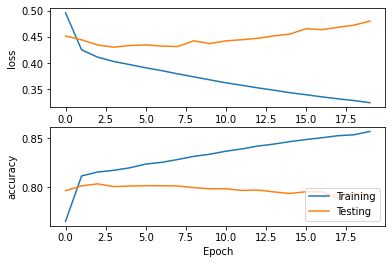

In [14]:
# Show loss and accuracy over epoch
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(fit1.history['loss'])
ax1.plot(fit1.history['val_loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')

ax2.plot(fit1.history['accuracy'])
ax2.plot(fit1.history['val_accuracy'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('accuracy')
ax2.legend(['Training', 'Testing'], loc='lower right')

**All 17323 parameters**
With our model now fit, lets take a look at the values for the 17313 parameters in our model.

In [ ]:
weights = model.get_weights()
[len(a) for a in weights] #In R, str(weights) is more descriptive

weights[0]
plt.hist(weights[0])
weights[1]

**Predictions:**
Lets see if we can gain further intuition by manually using the above parameter values for prediction. Below are the predicted probabilities from the model for the first five values in our training set.

In [24]:
# Predictions
np.round(model.predict(x_train[0:5,]),3)

array([[0.083, 0.917],
       [0.084, 0.916],
       [0.869, 0.131],
       [0.436, 0.564],
       [0.981, 0.019]], dtype=float32)

Lets see if we can manually compute these probabilities for the first five reviews in our training set using the computed weights shown previously. **If you understand this chunk you have mastered  basic elements of NN.**

In [25]:
# Manually compute probabilities using layer weights
n5 = 5 # number of predictions

# first layer: z_1 = W_1 X + b_1; a_1 = ReLU(z_1)
z_1 = np.dot(x_train[0:n5, ], weights[0]) # matrix shapes: [5,1072] * [1072,16] = [5,16]
# add beta (weights[[2]]) to every row 
z_1 = z_1 + weights[1] # np.shape(z_1)
a_1 = np.maximum(0,z_1) # np.shape(a_1)

# second layer: z_2 = W_2 a_1 + b_2; a_2 = ReLU(z_2)
z_2 = np.dot(a_1, weights[2])
z_2 = z_2 + weights[3]
a_2 = np.maximum(0, z_2)

# output layer: softmax(W_3 a_2 + b_3)
z_out = np.dot(a_2, weights[4])
z_out = z_out + weights[5] # np.shape(z_out)
softmax = lambda x: np.exp(x)/np.sum(np.exp(x)) # Define the softmax function
prob_pred = np.apply_along_axis(softmax,1,z_out)

np.round(prob_pred,3)

array([[0.083, 0.917],
       [0.084, 0.916],
       [0.869, 0.131],
       [0.436, 0.564],
       [0.981, 0.019]])

Its really that simple! The model would then continue computing the probabilities for the remainder of the reviews in our training set and then feed these numbers into our loss function. The value computed by our loss function on our training data is as follows:

In [26]:
fit1.history['loss'][19] #fit1.history keeps all evaluations

0.32458269596099854

### Tuning Parameter Selection  

From the graph below we see that by about 6 epochs our validation loss has bottomed out and we receive no further benefit from additional iterations

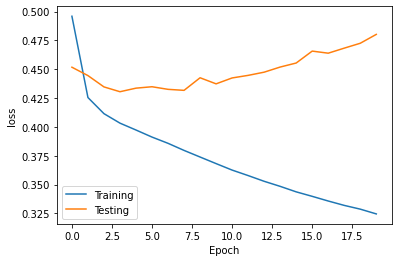

In [27]:
# TODO recycle plot from before, preferably
fig, (ax1) = plt.subplots(1,1)
ax1.plot(fit1.history['loss'])
ax1.plot(fit1.history['val_loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend(['Training', 'Testing'], loc='lower left')

To avoid overfitting lets use 6 epochs in our final model. (We could also play with unit numbers and batch size to see if this has an impact). Now that we are ready to fit our final model we can use all of training data.

Here we have put all the steps together to get the final NN predictive equation
* Training data: x_train, y_train
* Validation data: x_val, y_val
* NN model:
  + two layers with 16 and 8 neurons in each layer
  + Activation function is `Relu`
  + Output layer is `Sigmoid`
* Epoch is 6

In [28]:
# Model Architecture Definition
tf.random.set_seed(10) # Set seed for reproduceability

p = x_train.shape[1] #Note, Python uses index 0

model = keras.Sequential(
    [
     layers.Dense(units = 16, activation="relu", input_shape=(p,), name="layer1"),
     layers.Dense(units = 8, activation="relu", name="layer2"),
     layers.Dense(units = 2, activation="softmax", name="layer3")
    ]
)

y = model(x_train) # Initialize the model

model.compile(
    optimizer = "rmsprop",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

# Fit the model
fit2 = model.fit(
    x=x_train,
    y=y_train,
    epochs=6, # we reduce the number of epochs here
    batch_size=512,
    validation_split = 0.15
)

Epoch 1/6
150/150 [==============================] - 2s 9ms/step - loss: 0.4960 - accuracy: 0.7651 - val_loss: 0.4518 - val_accuracy: 0.7964
Epoch 2/6
150/150 [==============================] - 1s 8ms/step - loss: 0.4255 - accuracy: 0.8115 - val_loss: 0.4445 - val_accuracy: 0.8013
Epoch 3/6
150/150 [==============================] - 1s 8ms/step - loss: 0.4115 - accuracy: 0.8155 - val_loss: 0.4347 - val_accuracy: 0.8034
Epoch 4/6
150/150 [==============================] - 1s 8ms/step - loss: 0.4033 - accuracy: 0.8173 - val_loss: 0.4305 - val_accuracy: 0.8007
Epoch 5/6
150/150 [==============================] - 1s 8ms/step - loss: 0.3973 - accuracy: 0.8198 - val_loss: 0.4336 - val_accuracy: 0.8012
Epoch 6/6
150/150 [==============================] - 1s 8ms/step - loss: 0.3912 - accuracy: 0.8236 - val_loss: 0.4348 - val_accuracy: 0.8016


### Assessing Performance  

We can use the evaluate function to assess our performance on the validation data to report a final performance of the model built. 

In [29]:
results = model.evaluate(x_val, y_val)
results

313/313 [==============================] - 0s 1ms/step - loss: 0.4324 - accuracy: 0.8032


[0.43239668011665344, 0.8032000064849854]

Our accuracy on the validation data is an impressive 80% (20% of mis-classification error) with only two fully connected layers! Meaning that we correctly classified 80% of the reviews as positive or negative (this is a misclassification error of 20). With additional layers and different types of layers we could improve on this even further.

### Prediction  

Finally we can do prediction. Let us see how well we predict the first 5 reviews in the validation data. 

**Get probabilities:**

In [30]:
pred_prob = model.predict(x_val[0:5,])
pred_prob

array([[0.4605105 , 0.53948945],
       [0.698869  , 0.30113098],
       [0.47268614, 0.52731377],
       [0.02013831, 0.97986174],
       [0.43759486, 0.56240505]], dtype=float32)

**Get the labels:**

In [31]:
pred_labels = model.predict_classes(x_val[0:5,])
pred_labels

pd.DataFrame({'yhat': pred_labels, 'y': y_val[0:5,]})

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,yhat,y
0,1,0
1,0,0
2,1,1
3,1,1
4,1,1


# Summary and Remarks

We have introduced Neural network and implemented it using keras. Neural network provides a non-linear model to predict response variables. They can be catagorical or continuous responses. 

We have run Yelp review case study apply dense layers. Since we have used bag of words to process the data. So the advantage of Neural nets are not seen here. 

Many open questions re NN models

* **How many layers and how deep within each layer?**
* **Which activation function to use in each layer?**

Often we may adopt existing successful studies

* **Apply their architecture**
* Often we may input their weights as initial values 

In the next section we will apply NN's to image recognition case study. The accuracy of prediction is shown much better there. 

# Case 2: Multiclass Classification (MNIST)

## Image classification (MNIST)

### MNIST Dataset

Modified National Institute of Standards and Technology dataset (NNIST) (see details about the data http://yann.lecun.com/exdb/mnist/index.html) is 

* Collection of handwritten digits, from 0 to 9
* 60,000 training and 10,000 testing images
* Essentially a multinomial classification problem 
* Commonly used for training image recognition systems
* Useful because relatively 'clean' and well-labeled
* Very [well-studied](http://yann.lecun.com/exdb/mnist/index.html)

*Objective*: classify handwritten numbers from 0 to 9 correctly

The data has been used since 1998 to test the performance of a newly proposed method. As our first image processing case study we will immplement simple NN models below. The purpose is to get the model working. Nevertheless, it shows how powerful/accurate NN models are for image data. We continue to run a more complex, state of the art Convolution Neural Network in a separate lecture to see further error reduction. 


The data is available with `keras` package and it can be loaded as follows:

In [32]:
mnist = keras.datasets.mnist.load_data(path="mnist.npz")
(train_images, train_labels), (test_images, test_labels) = mnist

11493376/11490434 [==============================] - 0s 0us/step


Let's take a look at the data structure. The `x` are images of size 28x28 pixels and `y` labels which digits the image actually is.

In [33]:
v1 = np.shape(train_images)
v2 = np.shape(train_labels)

v3 = np.unique(train_labels) # 10 Digits
v4 = np.bincount(train_labels) # Frequencies (not unbalanced)

print(v1, v2, v3, v4, sep='\n')

(60000, 28, 28)
(60000,)
[0 1 2 3 4 5 6 7 8 9]
[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


Let's take a look at some images from the training set. We use imshow() from matplotlib to view the images. 

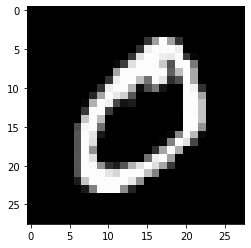

In [34]:
# Viewing one image
image = Image.fromarray(train_images[1,:,:])
plt.imshow(image, cmap='gray')

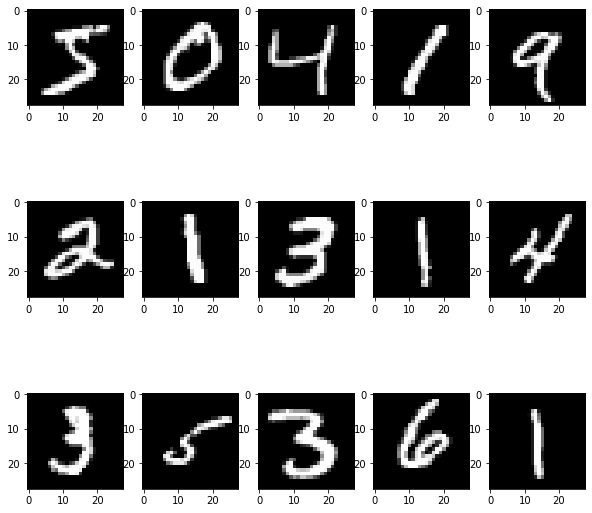

In [35]:
# Show 15 examples of images from the MNIST dataset
fig = plt.figure(figsize=(10,10))
rows = 3
columns = 5
index = 0

for i in range(0,rows):
  for j in range(0,columns):
    fig.add_subplot(rows,columns,index+1) # adjust +1 for matplotlib indexing
    image = Image.fromarray(train_images[index,:,:])
    plt.imshow(image, cmap='gray')
    index += 1

### Image vectorization

Images are just a matrix of pixels. Usually we use three color channels, red, green and blue. Each pixel is a 3-tuple that indicates how much we want from (red, green, blue) ranging from 0 to 255. For example, (255, 0, 0) represents red and (255, 255, 0) represents yellow. Black and white is represented as (0,0,0) and (255,255,255) respectively. For black and white pictures, there will be only one color channel so each pixel only has one number indicating darkness, which is called greyscale. To summarize,

- Images are 2D matrix (black and white)
- Values are a representation of color
- In this case, a number from 0 to 255 represents darkness
- Each image is represented as a 28x28 matrix, with values between 0 and 255 
- Translates into $X_1, X_2...X_{784}$ continuous variables
- Goal is to predict $Y$, what the digit is, between 0 and 9
- Image recognition is transformed to a classification problem
- Large dimension problems
- For color image, there will be 3 color channels (RGB) and sometimes additionally an alpha channel for opacity. Then images are represented as 3D matrix.

We can vectorize the 2D matrix using the function `np.reshape()` as follows:

In [36]:
# Preprocess dataset format for keras
d1, d2, d3 = train_images.shape
train_images = train_images.reshape(d1, d2*d3) # Flattens 2D imgs into 1D vector
train_images[1,:]
train_images = train_images/255 # Make values between 0 and 1
np.shape(train_images)

d1, d2, d3 = test_images.shape
test_images = test_images.reshape(d1, d2*d3)
test_images = test_images/255

# One-hot encode the labels for keras
train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

### Multiple outcome classifications

It is an easy extension to handle multiple classes from a binary settings. We will use logit function to model the probability of y being in each class j. 

- $P(y=j|x_1, \ldots, x_{784}) = \frac{e^{s_j}}{\sum_{j=1}^{j=10} e^{s_j}}$
- Use plurality rule to get a label $\hat y = \arg\max_{j} {P(y=j)}$
- Use entropy to estimate all the weights (unknown parameters).

### Fully Connected Neural Network


We are now ready to build a NN to first estimate the probability of each input and use polarity vote to get a label. 

The set up for a multiclass classification neural network is very similar to what we did for binary classification, with a few notable differences. Firstly, each input now has two dimensions (a 28x28 matrix representing the height and width of each image). To save time, the optimal values for the hyper parameters have been identified using the methods described previously. The output unit value is 10 as we have 10 possible label classifications: 0 to 9. 


The compiler settings are all the same except that for our loss function we use categorical cross entropy rather than binary cross entropy. This is similar to our binary function implementation, except that it allows for multiple classifications.

We start a NN model with 1 layer, 512 neurons and activated with `relu` function. The probability of each outcome is obtained via the softmax transformation. 

In [37]:
# Define & train the model
tf.random.set_seed(10) # Set seed for reproduceability

model = keras.Sequential(
    [
     layers.Dense(units = 512, activation="relu", input_shape=(28*28,), name="layer1"),
     layers.Dense(units = 10, activation="softmax", name="layer2")
    ]
)

model.compile(
    optimizer = "rmsprop",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

mod_fit = model.fit(
    x=train_images,
    y=train_labels,
    epochs=10,
    batch_size=128,
    validation_split = 0.2
)

Epoch 1/10
375/375 [==============================] - 5s 11ms/step - loss: 0.2899 - accuracy: 0.9173 - val_loss: 0.1575 - val_accuracy: 0.9544
Epoch 2/10
375/375 [==============================] - 4s 11ms/step - loss: 0.1179 - accuracy: 0.9658 - val_loss: 0.1078 - val_accuracy: 0.9678
Epoch 3/10
375/375 [==============================] - 4s 11ms/step - loss: 0.0765 - accuracy: 0.9775 - val_loss: 0.1186 - val_accuracy: 0.9636
Epoch 4/10
375/375 [==============================] - 4s 11ms/step - loss: 0.0553 - accuracy: 0.9836 - val_loss: 0.0854 - val_accuracy: 0.9758
Epoch 5/10
375/375 [==============================] - 4s 11ms/step - loss: 0.0409 - accuracy: 0.9883 - val_loss: 0.0820 - val_accuracy: 0.9759
Epoch 6/10
375/375 [==============================] - 4s 11ms/step - loss: 0.0306 - accuracy: 0.9910 - val_loss: 0.0865 - val_accuracy: 0.9770
Epoch 7/10
375/375 [==============================] - 4s 11ms/step - loss: 0.0227 - accuracy: 0.9931 - val_loss: 0.0890 - val_accuracy: 0.9767

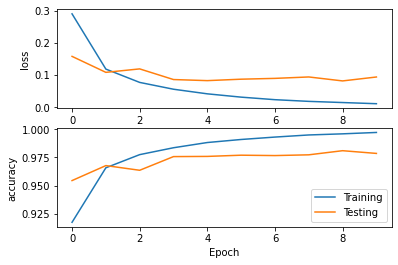

In [38]:
# Plot fit
# Show loss and accuracy over epoch
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(mod_fit.history['loss'])
ax1.plot(mod_fit.history['val_loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')

ax2.plot(mod_fit.history['accuracy'])
ax2.plot(mod_fit.history['val_accuracy'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('accuracy')
ax2.legend(['Training', 'Testing'], loc='lower right')

Lets see how we perform on the test data:

In [ ]:
results = model.evaluate(test_images, test_labels)
results

313/313 [==============================] - 1s 2ms/step - loss: 0.0772 - accuracy: 0.9802


[0.0771857425570488, 0.9801999926567078]

Our accuracy is **an amazing 98%!** Meaning that we correctly classified the number images 98% of the time!

# Conclusion

We took a glimpse at neural networks in this lecture. 
We learned how to model the perception process of human being using neural network. The basic elements of the neural network architecture are neurons and layers. There are lots of tuning parameters and thousands or millions of parameters to estimate. 

Using the `keras` package, we apply neural network to IMBD and MNIST. Since MNIST is image, we learned how to handle image data. We also did a real prediction using the model we trained.

# Appendix

## Python and Keras for R

Since Tensorflow and Keras are dependent on Python to run, to use them in RStudio we first need to install Python and use R interfaces to interact with those libraries. Here's the [link](https://www.anaconda.com/distribution/) to Python Anaconda distribution (version). Anaconda is a package manager and provides a one stop shop to install Python (and R) and some of the most popular libraries for data science. Anaconda Python also optimizes for numerical computation (because it is built against Intel's math kernel library). Note that for Windows users, in order to use Keras v2.2.4, you have to install the Anaconda distribution; otherwise for Mac/Linux users, you can either use Anaconda Python or [Vanilla Python](https://www.python.org/downloads/).

To develop neural network models, an R interface to Keras by RStudio is available. Here is an official [installation guide](https://tensorflow.rstudio.com/keras/reference/install_keras.html).

For further assistance see: https://keras.rstudio.com/ 
 - Detailed functions can be found in /API
 - Deep Learning keras cheat sheet: https://www.rstudio.com/resources/cheatsheets/